<a href="https://colab.research.google.com/github/trunghq0205/python4ds/blob/main/final_project_report.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Báo cáo cuối kỳ môn Python cho Khoa học Dữ liệu

Nhóm - Tên thành viên:
1. Hồ Ngọc Ân - 20280001
2. Trần Tuấn Thái - 20280082
3. Huỳnh Quang Trung - 20280108
4. Hỏa Ngọc Tú - 20280111

Github: https://github.com/trunghq0205/python4ds

----

## Thông tin bài nộp

**Thông tin bài nộp:**
- Link bản Colab: https://colab.research.google.com/drive/1yz3gMctzjuiQDRPzE4xapREU3I4lUWpT?usp=share_link

----

## Mô tả bài toán và nguồn gốc của tập dữ liệu

Đây là bộ dữ liệu về thông tin các chuyến taxi tại New York vào 6 tháng đầu năm 2016 dựa trên dữ liệu **[2016 NYC Yellow Cab trip record data](https://cloud.google.com/bigquery/public-data)** có sẵn trên BigQuery của Google Cloud Platform. Dữ liệu gốc được phát hành bởi NYC *Taxi and Limousine Commission (TLC)* và có sẵn trên trang [NYC TLC](https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page). Tập dữ liệu được dùng trong đồ án lần này đã được lấy mẫu (sample) và tiền xử lý để sử dụng cho cuộc thi **[New York City Taxi Trip Duration](https://www.kaggle.com/c/nyc-taxi-trip-duration/overview)** trên Kaggle vào năm 2017.

Mục tiêu của cuộc thi *New York City Taxi Trip Duration* là xây dựng một mô hình dự đoán tổng thời gian đi của các chuyến taxi ở Thành phố New York dựa vào các biến như thời gian đón, tọa độ địa lý, số lượng hành khách và một số biến số khác.

**Input:** Dữ liệu gồm 9 thuộc tính của một chuyến taxi (id, vendor_id, pickup_datetime, passenger_count, pickup_longitude, pickup_latitude, dropoff_longitude, dropoff_latitude, store_and_fwd_flag) \
**Output:** Tổng thời gian dự đoán của chuyến đi đó tính bằng giây.

----

## Cài đặt và gọi các thư viện cần thiết

In [1]:
# Bỏ dấu # để cài đặt các thư viện cần thiết được sử dụng trong bài làm.
#!pip install geopy
#!pip install pandas
#!pip install sklearn
#!pip install xgboost
#!pip install pickle-mixin
#!pip install folium
#!pip install basemap

In [2]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import geopy.distance
import seaborn as sns
plt.style.use('ggplot')
import folium
from mpl_toolkits.basemap import Basemap

import pickle
from sklearn.model_selection import train_test_split
import xgboost as xgb

/usr/local/lib/python3.8/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


----

## Khám phá dữ liệu

### Đọc dữ liệu từ file csv vào dataframe

Tại đây, chúng ta sẽ bắt đầu sử dụng hàm **read_csv** của thư viện pandas để load dữ liệu. Hai tập dữ liệu train.csv và test.csv được upload lên github nhằm mục đích có thể đọc được tập dữ liệu thông qua link raw data, giúp linh hoạt hơn trong việc chạy dược file notebook trong nhiều trường hợp khác nhau mà không phụ thuộc vào việc phải cần có file dữ liệu tại local.


In [3]:
taxi_df = pd.read_csv('https://media.githubusercontent.com/media/trunghq0205/python4ds/main/train.csv', index_col = None)
test = pd.read_csv('https://media.githubusercontent.com/media/trunghq0205/python4ds/main/test.csv', index_col = None)
taxi_df.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


### Dữ liệu gồm có bao nhiêu dòng và bao nhiêu cột?

Ta tiếp tục sử dụng phương thức **shape** của một đối tượng DataFrame để trả về một bộ kích thước mảng cho biết số lượng hàng và cột của nó.


In [4]:
num_rows = taxi_df.shape[0]  # Lấy giá trị đầu tiên trả về - tương ứng với hàng
num_cols = taxi_df.shape[1]  # Lấy giá trị thứ 2 trả về - tương ứng với cột
print(f'Tập dữ liệu train bao gồm {num_rows} dòng và {num_cols} cột.') # In ra dữ liệu với chức năng format

Tập dữ liệu train bao gồm 1458644 dòng và 11 cột.


Trong đó, mỗi dòng của tập dữ liệu là một bản ghi của một chuyến taxi theo 11 thuộc tính với các ý nghĩa khác nhau sẽ được trình bày chi tiết trong phần mô tả phía dưới.

### Dữ liệu có các dòng bị lặp không?

Vì dữ liệu ở cột id là duy nhất cho mỗi bản ghi, nên vì vậy ta sẽ tiến hành kiểm tra xem có bản ghi nào trùng lặp với nhau trong tập dữ liệu này hay không thông qua cách kiểm tra sự trùng lặp dữ liệu ở cột **id**

Ta sẽ lọc lấy dữ liệu ở cột id, sau đó dùng phương thức unique() để bỏ đi các giá trị trùng nhau. Nếu như kết quả thu được bằng với số dòng của tập dữ liệu thì không có bản ghi nào là trùng nhau.

In [5]:
if taxi_df['id'].unique().shape[0] == taxi_df.shape[0]:
  print('Không có dòng nào trùng lặp trong tập dữ liệu')
else:
  print('Có dòng dữ liệu trùng lặp')

Không có dòng nào trùng lặp trong tập dữ liệu


Có lẽ tập dữ liệu đã được ban tổ chức tiền xử lý trước để dùng trong cuộc thi nên trong tập dữ liệu của chúng ta không có các dòng dữ liệu bị trùng lặp với nhau.

### Mô tả ý nghĩa của các thuộc tính.

Tập dữ liệu test.csv đã xử lý gồm 11 cột, cột cuối cùng (trip_duration) là giá trị cần được dự đoán: \
**id** - một mã định danh duy nhất cho mỗi chuyến đi \
**vendor_id** - mã cho biết nhà cung cấp được liên kết với hồ sơ chuyến đi (vì thông tin không được thu thập và cung cấp bởi TLC mà được cung cấp bởi 2 nhà cung cấp khác nhau được đánh số là 1 và 2) \
**pickup_datetime** - Ngày và giờ khi đồng hồ của taxi bắt đầu tính số mét \
**dropoff_datetime** - ngày và giờ khi kết thúc tính số mét \
**passenger_count** - số hành khách trên phương tiện (tài xế nhập thông tin này) \
**pickup_longitude** - kinh độ nơi bắt đầu tính số kilomet \
**pickup_latitude** - vĩ độ nơi bắt đầu tính số mét \
**dropoff_longitude** - kinh độ nơi kết thúc tính số kilomet \
**dropoff_latitude** - vĩ độ nơi kết thúc tính số mét \
**store_and_fwd_flag** - đánh dấu 1 bản ghi có được ghi lại trong bộ nhớ của phương tiện trước khi được gửi đến cho nhà cung cấp không (điều này xảy ra vì phương tiện không có kết nối đến máy chủ khi di chuyển) \
**trip_duration** - thời gian của chuyến tính bằng giây

### Các thuộc tính mang kiểu dữ liệu gì?

Sử dụng **info()** để xem thông tin chi tiết của các cột có trong dataframe, mục đích chính ở đây sẽ là xem kiểu dữ liệu của từng cột.

In [6]:
taxi_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   id                  1458644 non-null  object 
 1   vendor_id           1458644 non-null  int64  
 2   pickup_datetime     1458644 non-null  object 
 3   dropoff_datetime    1458644 non-null  object 
 4   passenger_count     1458644 non-null  int64  
 5   pickup_longitude    1458644 non-null  float64
 6   pickup_latitude     1458644 non-null  float64
 7   dropoff_longitude   1458644 non-null  float64
 8   dropoff_latitude    1458644 non-null  float64
 9   store_and_fwd_flag  1458644 non-null  object 
 10  trip_duration       1458644 non-null  int64  
dtypes: float64(4), int64(3), object(4)
memory usage: 122.4+ MB


**Nhận xét**: Ở đây, có 4 thuộc tính mang kiểu dữ liệu object là id, pickup_datetime, dropoff_datetime và store_and_fwd_flag. Ta tiếp tục tiến hành xem các kiểu dữ liệu có trong các thuộc tính này.

Vì kiểu dữ liệu **object** có thể chứa nhiều kiểu khác nhau. Chẳng hạn, cột a có thể bao gồm số nguyên, số thực hoặc chuỗi và chúng sẽ được gắn nhãn chung là một object. Vì thế, ta sẽ tiến hành viết một hàm để xem các kiểu dữ kiệu có trong các cột mang kiểu object này.

In [7]:
def open_object_dtype(s):
    dtypes = set() # Kiểu dữ liệu set mang các giá trị là duy nhất
    dtypes.update((s.apply(lambda ele: type(ele)).to_numpy())) # Lấy kiểu dữ liệu của từng dòng trong cột sau đó thêm vào dtypes
    return dtypes

In [8]:
print(open_object_dtype(taxi_df['id']))
print(open_object_dtype(taxi_df['pickup_datetime']))
print(open_object_dtype(taxi_df['dropoff_datetime']))
print(open_object_dtype(taxi_df['store_and_fwd_flag']))

{<class 'str'>}
{<class 'str'>}
{<class 'str'>}
{<class 'str'>}


Ta thấy, tất các các phần tử tại các thuộc tính này đều mang kiểu dữ liệu là string. Để tiếp tục bài toán, tại đây ta có thể đưa ra các hướng giải quyết như sau:
- Đối với **id**: Đây là một mã định danh cho mỗi chuyến taxi nên ta có thể giữ nguyên kiểu dữ liệu của nó là string.
- Đối với **pickup_datetime** và **dropoff_datetime**: Ta sẽ chuyển chúng sang kiểu dữ liệu date_time để phù hợp với ngữ cảnh dữ liệu mà nó lưu trữ và thuận tiện để làm việc với 2 cột này.
- Đối với **store_and_fwd_flag**: Đây là cột mang ý nghĩa phân loại và đánh dấu, ta sẽ chuyển nó sang kiểu bool.

## Tiền xử lý dữ liệu

Dựa vào các quyết định ở phía trên, đầu tiên ta sẽ:
1. Chuyển **pickup_datetime** và **dropoff_datetime** về kiểu date_time
2. Chuyển **store_and_fwd_flag** về kiểu bool
3. Chuyển cột **id** sang kiểu dữ liệu str

### Chuyển cột **pickup_datetime** và **dropoff_datetime** sang datetime

In [9]:
taxi_df['pickup_datetime'] = pd.to_datetime(taxi_df['pickup_datetime'], format='%Y-%m-%d %H:%M:%S')
taxi_df['dropoff_datetime'] = pd.to_datetime(taxi_df['dropoff_datetime'], format='%Y-%m-%d %H:%M:%S')

### Chuyển cột **store_and_fwd_flag** sang kiểu bool

In [10]:
taxi_df['store_and_fwd_flag'] = taxi_df['store_and_fwd_flag'].apply(lambda temp: False if temp == 'N' else True)

### Chuyển cột **id** sang kiểu dữ liệu str

In [11]:
taxi_df['vendor_id'] = taxi_df['vendor_id'].astype(str)

Ta xem lại kiểu dữ liệu của các cột sau khi được xử lý

In [12]:
taxi_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
 #   Column              Non-Null Count    Dtype         
---  ------              --------------    -----         
 0   id                  1458644 non-null  object        
 1   vendor_id           1458644 non-null  object        
 2   pickup_datetime     1458644 non-null  datetime64[ns]
 3   dropoff_datetime    1458644 non-null  datetime64[ns]
 4   passenger_count     1458644 non-null  int64         
 5   pickup_longitude    1458644 non-null  float64       
 6   pickup_latitude     1458644 non-null  float64       
 7   dropoff_longitude   1458644 non-null  float64       
 8   dropoff_latitude    1458644 non-null  float64       
 9   store_and_fwd_flag  1458644 non-null  bool          
 10  trip_duration       1458644 non-null  int64         
dtypes: bool(1), datetime64[ns](2), float64(4), int64(2), object(2)
memory usage: 112.7+ MB


### Thêm cột distance vào tập dữ liệu

Dựa vào tọa độ điểm đón và trả khách được cung cấp trong tập dữ liệu, ta sẽ tiến hành tính khoảng cách di chuyển của chuyến xe bằng cách sử dụng thư viện bổ trợ là geopy. Khoảng cách tính được ở đơn vị km

In [13]:
# Define hàm tính khoảng cách chuyến đi
def get_distance(trip):
    pickup_coord = (trip['pickup_latitude'], trip['pickup_longitude'])
    dropoff_coord = (trip['dropoff_latitude'], trip['dropoff_longitude'])
    return geopy.distance.distance(pickup_coord, dropoff_coord).km

Theo tài liệu của thư viện geopy thì **geopy.distance.distance** sử dụng khoảng cách trắc địa (geodesic distance) để tính toán khoảng cách giữa 2 điểm. 
Khoảng cách trắc địa là khoảng cách ngắn nhất trên bề mặt của mô hình hình elip của trái đất.
Tìm hiểu thêm về geodesic distance tại: https://en.wikipedia.org/wiki/Geodesics_on_an_ellipsoid

Để hiểu rõ hơn, có thể tham khảo thêm tài liệu và cách thư viện geopy tính toán các khoảng cách tại: https://geopy.readthedocs.io/en/stable/#module-geopy.distance

In [14]:
#Bỏ dấu comment để chạy code, ở đây để tiết kiệm thời gian nhóm đã chạy trước và sẽ lấy kết quả có sẵn.
#distances = taxi_df.apply(get_distance, axis=1)
#distances.to_csv('distance.csv', index=False)

In [15]:
taxi_df['distance'] = pd.read_csv('https://media.githubusercontent.com/media/trunghq0205/python4ds/main/distance.csv')

In [16]:
taxi_df.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,distance
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,False,455,1.502172
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,False,663,1.808660
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,False,2124,6.379687
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,False,429,1.483632
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,False,435,1.187038


### Thêm cột speed (tốc độ) vào tập dữ liệu

Ở đây chúng ta sẽ tính tốc độ của chuyến đi thông qua công thức tính vận tốc đơn giản là quãng đường/thời gian: V = S/t và quy về đơn vị km/h
\begin{align}
        V = \frac{S\,}{t}
    \end{align}

In [17]:
# Thiết kế hàm tính tốc độ của chuyến đi
def get_speed(trip):
    return trip['distance']/trip['trip_duration']

In [18]:
# Bỏ dấu comment để chạy code, ở đây để tiết kiệm thời gian nhóm đã chạy trước và sẽ lấy kết quả có sẵn 
#speed = taxi_df.apply(get_speed, axis=1)
#speed.to_csv('speed.csv', index=False)

In [19]:
taxi_df['speed'] = taxi_df.distance/taxi_df.trip_duration*3600 #đổi ra đơn vị km/h

In [20]:
taxi_df.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,distance,speed
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,False,455,1.502172,11.885316
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,False,663,1.808660,9.820778
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,False,2124,6.379687,10.813029
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,False,429,1.483632,12.450063
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,False,435,1.187038,9.823760


## Khám phá dữ liệu (tiếp tục)

### Ở phần này, ta sẽ bắt đầu tìm hiểu riêng một số thuộc tính của tập dữ liệu

In [21]:
nume_col_df = taxi_df[["passenger_count", "pickup_datetime", "dropoff_datetime","pickup_latitude", "pickup_longitude", "dropoff_latitude", \
                      "dropoff_longitude", "trip_duration", "distance", "speed"]]

In [22]:
# Thiết kế hàm tính phần trăm các giá trị NA trong từng cột
def missing_ratio(s):
    return s.isna().mean() * 100

In [23]:
nume_col_df = nume_col_df.agg([missing_ratio, min, max]);
nume_col_df

,passenger_count,pickup_datetime,dropoff_datetime,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude,trip_duration,distance,speed
missing_ratio,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
min,0.0,2016-01-01 00:00:17,2016-01-01 00:03:31,34.359695,-121.933342,32.181141,-121.933304,1.0,0.000000,0.000000
max,9.0,2016-06-30 23:59:39,2016-07-01 23:02:03,51.881084,-61.335529,43.921028,-61.335529,3526282.0,1240.510256,9279.581773


Dựa vào bảng kết quả trên ta có nhận xét như sau:
- Tất cả các thuộc tính đều không có giá trị Na (giá trị bị thiếu)
- Có chuyến đi với số lượng hành khách thấp nhất là 0 và cao nhất là 9 người. Chúng ta sẽ tìm hiểu vấn đề này trong phần tiếp theo.
- Có chuyến đi với thời gian di chuyển chỉ 1 giây với quãng đường di chuyển là 0 km. Đây là chuyến đi với thời gian ngắn bất thường
- Chúng ta có các chuyến đi với độ dài trip_duration lên tới 3526282 giây, tương ứng với hơn 40 ngày. Có chuyến đi với quãng đường lên tới 1240.5 km, đặc biệt hơn còn có chuyến đi có tốc độ lên tới 9279.58 km/h. Ngoài ra, chúng ta còn có các chuyến đi có vẻ không di chuyển với quãng đường và tốc độ bằng 0. Đây đều là những chuyến đi có thuộc tính rất bất thường.

### Khảo sát cột **passenger_count**

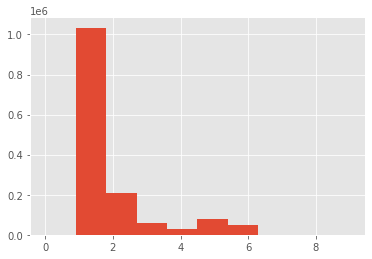

In [24]:
plt.hist(taxi_df['passenger_count']);

In [25]:
taxi_df['passenger_count'].value_counts()

1    1033540
2     210318
5      78088
3      59896
6      48333
4      28404
0         60
7          3
9          1
8          1
Name: passenger_count, dtype: int64

Nhận xét:
- Ta thấy phần lớn các chuyến đi sẽ có số lượng là 1 hành khách với 1033540 bản ghi, tiếp sau đó là 2 người với 210318 bản ghi. Đối với các chuyến đi có từ 3 đến 6 hành khách cũng có số lượng nhất định nằm trong khoảng từ 30000 đến 80000 bản ghi
- Ta cũng thấy có 60 chuyến đi với số lượng là 0 hành khách, đối với các chuyến có 7 8 9 hành khách cũng có rất ít bản ghi.

Vì tồn tại các dòng dữ liệu với các số liệu bất thường, đồng thời chúng cũng chiếm phần thiểu số trong tập dữ liệu, nên ta quyết định sẽ xóa bỏ các dòng có số lượng hành khách là 0, 7, 8 và 9 ra khỏi tập dữ liệu.

### Khảo sát cột **trip_duration** và **distance**

In [26]:
taxi_df["trip_duration"].sort_values(ascending=False)[:15]

978383     3526282
924150     2227612
680594     2049578
355003     1939736
1234291      86392
295382       86391
73816        86390
59891        86387
1360439      86385
753765       86379
1221666      86378
91717        86378
1138915      86377
66346        86377
1284067      86369
Name: trip_duration, dtype: int64

Nhận xét:
- Có 4 chuyến đi với với thời lượng di chuyển khá lớn từ gần 2 triệu giây đến hơn 3.5 triệu giây (kéo dài tời hơn 40 ngày).
- Ngoài 4 chuyến đi với thời lượng di chuyển rất lớn ở phía trên, thì các chuyến đi còn lại trong tập dữ liệu sẽ có trip_duration không vượt quá 86400 giây.

Tiếp theo, ta sẽ quan sát sự phân bố về số lượng các chuyến taxi có **trip_duration** nằm trong các khoảng (0-5000) giây, (5000, 10000), (10000, 80000), (80000, 82000), (82000, 83000), (83000, 84000) và (84000, 84600).

Text(0, 0.5, 'count')

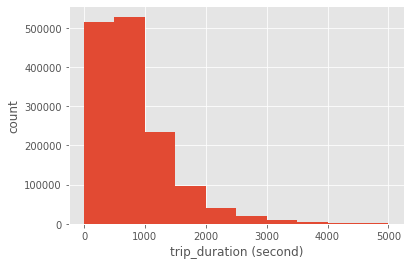

In [27]:
plt.hist(taxi_df['trip_duration'], range=(0, 5000))
plt.xlabel('trip_duration (second)')
plt.ylabel('count')

Text(0, 0.5, 'count')

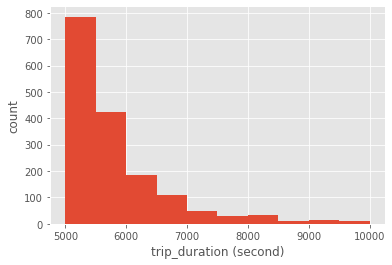

In [28]:
plt.hist(taxi_df['trip_duration'], range=(5000, 10000))
plt.xlabel('trip_duration (second)')
plt.ylabel('count')

Text(0, 0.5, 'count')

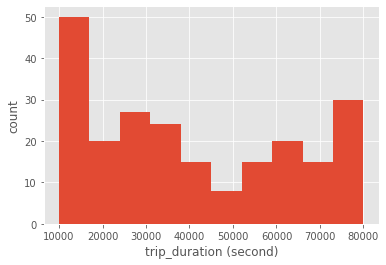

In [29]:
plt.hist(taxi_df['trip_duration'], range=(10000, 80000))
plt.xlabel('trip_duration (second)')
plt.ylabel('count')

Text(0, 0.5, 'count')

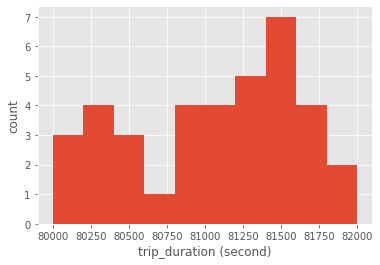

In [30]:
plt.hist(taxi_df['trip_duration'], range=(80000, 82000))
plt.xlabel('trip_duration (second)')
plt.ylabel('count')

Text(0, 0.5, 'count')

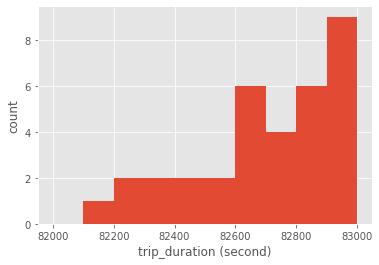

In [31]:
plt.hist(taxi_df['trip_duration'], range=(82000, 83000))
plt.xlabel('trip_duration (second)')
plt.ylabel('count')

Text(0, 0.5, 'count')

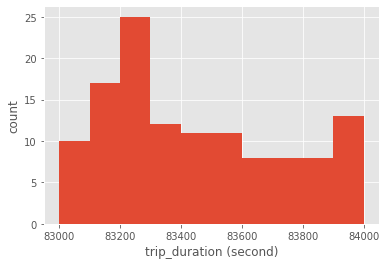

In [32]:
plt.hist(taxi_df['trip_duration'], range=(83000, 84000))
plt.xlabel('trip_duration (second)')
plt.ylabel('count')

Text(0, 0.5, 'count')

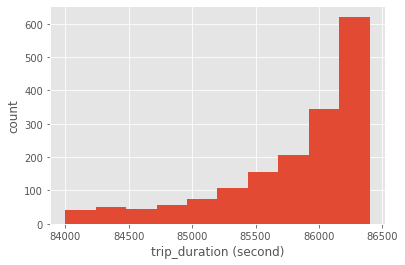

In [33]:
plt.hist(taxi_df['trip_duration'], range=(84000, 86400))
plt.xlabel('trip_duration (second)')
plt.ylabel('count')

**Nhận xét:**
- Các chuyến đi trong tập dữ liệu phần lớn có trip_duration từ 3000 giây trở về trước với số lượng bản ghi rất lớn so với các miền giá trị còn lại. Chỉ riêng với khoảng từ 0 tới 1000 giây đã có tới hơn 1 triệu bản ghi trong khi tập dữ liệu chỉ gần 1 triệu rưỡi dòng.
- Trong khoảng từ 7000 giây đến 86400 giây chúng ta có khá ít bản ghi mặc dù đây là một miền giá trị rất dài, dài hơn rất nhiều so với miền giá trị trước đó nhưng so về số lượng bản ghi thì ít hơn rất nhiều.
- Ta nhận thấy từ cột mốc 82600s trở lên thì số lượng bản ghi có xu hướng tăng. Đây là một khoảng giá trị trip_duration vô cùng lớn vì nó kéo dài tới hơn 1 ngày (quá dài so với 1 chuyến taxi thông thường trong một thành phố). Và thông qua các biểu đồ, ta cũng nhận thấy rằng khi thời lượng của trip_duration càng lớn thì số lượng bản ghi có xu hướng giảm đi. Điều này là hợp lý vì thời lượng của các chuyến taxi thường không dài đến thế và các chuyến đi này chỉ là thiểu số hoặc không tồn tại ở ngoài thực tế. Vì vậy, việc có nhiều chuyến taxi có trip_duration kéo dài tới xấp xỉ hơn 1 ngày trở lên tăng lên bất ngờ như thế là một bất thường.

Ta cũng sẽ xem tốc độ và quãng đường của các chuyến đi có trip_duration >= 82600

(array([1.13e+03, 4.16e+02, 1.32e+02, 7.50e+01, 2.50e+01, 1.20e+01,
        4.10e+01, 1.90e+01, 0.00e+00, 1.00e+00]),
 array([ 0.,  3.,  6.,  9., 12., 15., 18., 21., 24., 27., 30.]),
 <a list of 10 Patch objects>)

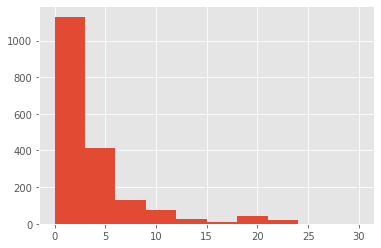

In [34]:
plt.hist(taxi_df[taxi_df['trip_duration'] >= 82600]['distance'], range=(0,30))

Ta nhận thấy tuy là có thời lượng di chuyển rất dài nhưng các chuyến đi này phần lớn đều di chuyển dưới 10km. Đây là một bất thường khá lớn khi thời gian di chuyển lâu nhưng lại đi được cự ly rất ngắn.

(array([1.55e+03, 2.06e+02, 3.60e+01, 5.80e+01, 1.00e+00, 0.00e+00,
        1.00e+00, 0.00e+00, 0.00e+00, 1.00e+00]),
 array([0.        , 0.25465655, 0.50931311, 0.76396966, 1.01862621,
        1.27328277, 1.52793932, 1.78259587, 2.03725243, 2.29190898,
        2.54656553]),
 <a list of 10 Patch objects>)

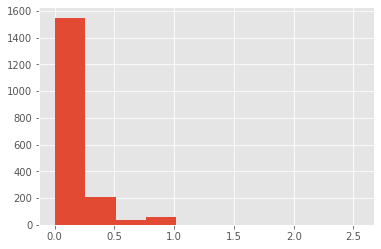

In [35]:
plt.hist(taxi_df[taxi_df['trip_duration'] >= 82600]['speed'])

Ngoài ra các chuyến đi này còn có tốc độ rất chậm khi tất cả đều có tốc độ dưới 1 km/h.

**Quyết định: Thông qua các khảo sát phía trên, ta quyết định xóa các chuyến đi có thuộc tính trip_duration lớn hơn 82600 giây.**

Ngoài các chuyến đi quá dài thì chúng ta cũng cần quan tâm đến các chuyến đi có độ dài quá ngắn. Dựa vào thông tin ở phần trước, chúng ta đã biết giá trị bé nhất của cột trip_duration là 1 giây nên vì vây ta sẽ tiến hành đếm số lượng các chuyến có thời lượng 1 giây.

In [36]:
taxi_df[taxi_df["trip_duration"] == 1].shape[0]


33

Mở rộng ra với các chuyến có độ dài bé hơn 120 giây:

In [37]:
taxi_df[taxi_df["trip_duration"] < 120].shape[0]

27817

Ta nhận thấy các chuyến xe dưới 2 phút có số lượng 27817 bản ghi, có thể các chuyến này là do khách hàng hủy chuyến hoặc khách hàng đổi ý khi xe chỉ mới vừa lăn bánh.

Tiếp theo, ta sẽ tiến hành xem thử khoảng cách di chuyển của các chuyến xe có trip_duration bé hơn 120 giây là bao nhiêu.

Text(0, 0.5, 'count')

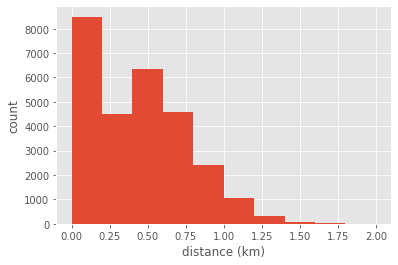

In [38]:
plt.hist(taxi_df[taxi_df['trip_duration'] < 120]['distance'], range=(0, 2))
plt.xlabel('distance (km)')
plt.ylabel('count')

Ta thấy phần lớn các chuyến đi dưới 120 giây đều có khoảng cách di chuyển bé hơn 1km, điều này là hợp lý bởi vì với một khoảng thời gian ngắn như thế thì sẽ không di chuyển được xa. Điều này cho thấy luận điểm khách hàng hủy chuyến hoặc đổi ý trong quá trình di chuyển là có cơ sở tin tưởng được.

Ta sẽ tiếp tục làm việc với các chuyến có quãng đường là 0km

In [39]:
distance_zero = taxi_df[taxi_df['distance'] == 0]
distance_zero.shape[0]

5897

Chúng ta có 5897 chuyến đi với khoảng cách là 0km

Ta tiếp tục xem thời lượng di chuyển của các chuyến có độ dài quãng đường bằng 0.

Text(0, 0.5, 'count')

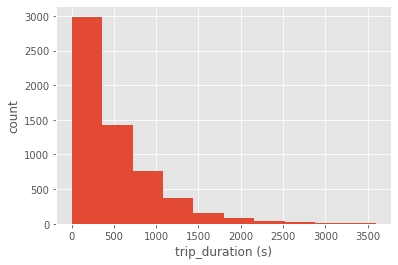

In [40]:
plt.hist(distance_zero['trip_duration'], range=(0, 3600))
plt.xlabel('trip_duration (s)')
plt.ylabel('count')

In [41]:
distance_zero[distance_zero['trip_duration'] < 120].shape[0]

1935

Như vậy là chúng ta có 1935 chuyến đi không di chuyển mà có trip_duration dưới 120 giây. Các chuyến còn lại có trip_duration trải dài từ 120 giây đến 3600 giây tương ứng với gần 1 giờ.

**Quyết định: Ta sẽ xóa các chuyến xe không di chuyển mà có trip_duration lớn hơn 120 giây và giữ lại các chuyến xe có trip_duration bé hơn 120 giây vì có thể các chuyến này bị hủy bởi khách hàng khi xe chưa di chuyển.**

### Khảo sát cột **speed**

In [42]:
taxi_df["speed"].sort_values(ascending=False)[:20]

1176337    9279.581773
910072     6874.214785
184925     5638.682980
974378     5253.665463
377068     4090.789812
1013474    1760.893664
923793     1442.634083
906281     1410.612913
1001028    1408.750365
595540     1355.140122
275644     1292.957998
1107       1266.014753
898154     1243.162682
644165     1137.259158
777670     1094.027657
283102      951.259095
1322903     928.984704
1200843     912.431995
259403      910.453922
467645      835.257183
Name: speed, dtype: float64

(array([117899., 535641., 448293., 203574.,  85587.,  37724.,  18034.,
          7682.,   2679.,    844.]),
 array([ 0.,  6., 12., 18., 24., 30., 36., 42., 48., 54., 60.]),
 <a list of 10 Patch objects>)

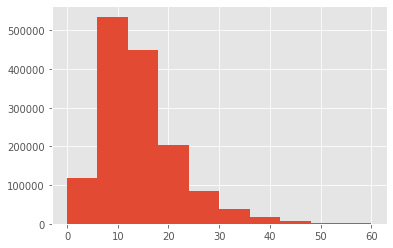

In [43]:
plt.hist(taxi_df["speed"], range=(0, 60))

In [44]:
number_of_under_60_speed = taxi_df[taxi_df["speed"] <= 100].shape[0]
number_of_under_60_speed

1458469

Ta thấy phần lớn các chuyến xe đều có tốc dộ di chuyển dưới 100km/h với tổng số 1.458.469 bản ghi. Đây là một tốc độ bình thường đối với các chuyến taxi trong thành phố.

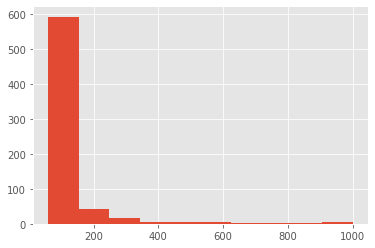

In [45]:
plt.hist(taxi_df["speed"], range=(60, 1000));

Đối với các chuyến xe có tốc độ di chuyển từ 60km/h trở lên không chiếm số lượng nhiều, trong đó tốc độ từ 60km/h đến 100km/h chiếm phần lớn.

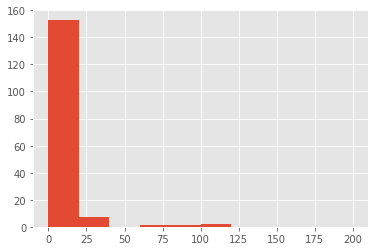

In [46]:
plt.hist(taxi_df[taxi_df['speed'] >=100]['distance'], range=(0,200));

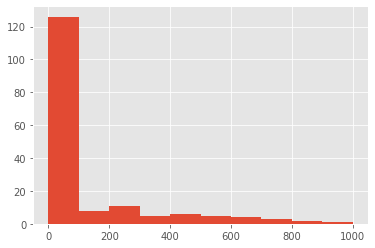

In [47]:
plt.hist(taxi_df[taxi_df['speed'] >=100]['trip_duration'], range=(0, 1000));

**Quyết định: Xóa các chuyến đi có tốc độ di chuyển lớn hơn 100km/h**

## Tiền xử lý dữ liệu (tiếp theo)

### Xóa các bản ghi có passenger_count = 0, 7, 8, 9

In [48]:
taxi_df.drop(taxi_df[taxi_df['passenger_count'].isin([0, 7, 8, 9])].index, inplace = True)

### Xóa các chuyến có trip_duration lớn hơn 82600

In [49]:
taxi_df.drop(taxi_df[taxi_df['trip_duration'] > 82600].index, inplace = True)

### Xóa các chuyến có distance = 0 và trip_duration lớn hơn 120 giây

In [50]:
distance_zero = taxi_df[taxi_df['distance'] == 0]
taxi_df.drop(distance_zero[distance_zero['trip_duration'] > 120].index, inplace=True)

### Xóa các chuyến có tốc độ di chuyển từ 100km/h trở lên.

In [51]:
taxi_df.drop(taxi_df[taxi_df['speed'] >= 100].index, inplace = True)

In [52]:
taxi_df.reset_index(drop=True, inplace=True)

In [53]:
taxi_df.shape[0]

1452600

## Khám phá dữ liệu (tiếp tục)

Với mỗi cột có kiểu dữ liệu dạng categorical, các giá trị được phân bố như thế nào?

vendor_id và store_and_flag là 2 cột có kiểu dữ liệu dạng categorical.

vendor_id : mã cho biết nhà cung cấp được liên kết với hồ sơ chuyến đi.

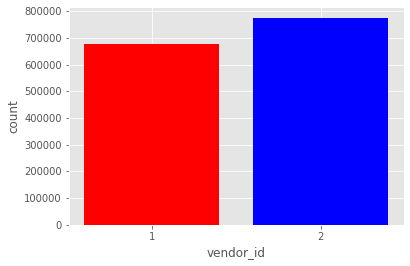

In [54]:
vendor_counts = taxi_df['vendor_id'].value_counts(ascending=True)
plt.bar(vendor_counts.index, vendor_counts.values, color=['red', 'blue'])
plt.xlabel('vendor_id')
plt.ylabel('count');

Dựa vào biểu đồ trên ta thấy Vendor 2 cung cấp nhiều hơn Vendor 1 khoảng 100K bản ghi.

In [55]:
vendor_counts

1    677432
2    775168
Name: vendor_id, dtype: int64

So sánh sự khác biệt giữa Vendor_id 1 và Vendor_id 2.

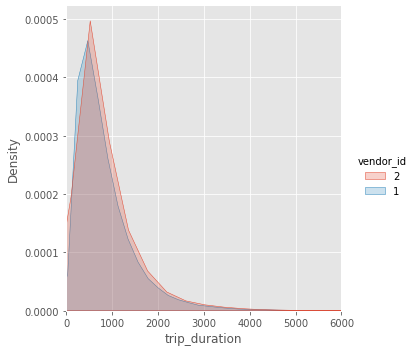

In [56]:
sns.displot(taxi_df[:300000] , x='trip_duration',kind="kde", hue='vendor_id', fill=True)
plt.xlim(-10, 6000);

Nhận thấy sự khác biệt giữa  Vendor_id 1 và Vendor_id 2 là không đáng kể.

Khám phá cột store_and_fwd_flag 

In [57]:
(taxi_df['store_and_fwd_flag'] == True).mean()*100

0.5519069255128735

Khoảng 0.55% các chuyến có bản ghi được ghi lại trong bộ nhớ của phương tiện trước khi được gửi đến cho nhà cung cấp.


Ta tiếp tục tìm hiểu mối liên hệ của nó với trip_duration.

Text(0, 0.5, 'densityfc')

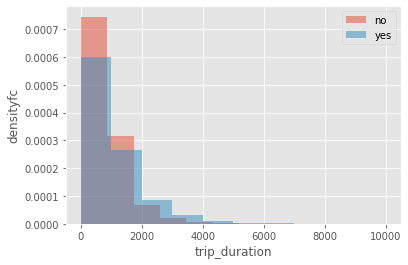

In [58]:
store_no = taxi_df[~taxi_df['store_and_fwd_flag']]['trip_duration']
store_yes = taxi_df[taxi_df['store_and_fwd_flag']]['trip_duration']
plt.hist(store_no[:100000],range=(2.00000e+00, 8.63750e+03), label='no', density=True, alpha=0.5)
plt.hist(store_yes, label='yes', density=True, alpha=0.5)
plt.legend(loc='upper right')
plt.xlabel('trip_duration')
plt.ylabel('densityfc')

Dựa vào biểu đồ trên, ta nhận thấy sự khác biệt không đáng kể. Vì vậy sẽ không khám phá thêm về thuộc tính này.

## Phân tích dữ liệu

---





Mục tiêu của bài toán là trip_duration nên nhóm mình đặt ra các câu hỏi về ảnh hưởng của thời gian và địa điểm của điểm đón/trả liệu có ảnh hưởng đến trip_duration. Trên thực tế, thời gian và địa điểm có ảnh hưởng đến độ dài chuyến đi, có thể vào giờ cao điểm ở một số khu vực sẽ bị di chuyển chậm hơn bình thường. Để trả lời cho các giả thuyết này, chúng ta sẽ đi qua 2 câu hỏi lớn:

###**Câu hỏi phân tích số 1:** Trip_duration thay đổi như thế nào theo các ngày trong tuần và các giờ trong ngày?

Tiếp theo, ta sẽ tiếp cận với 3 khung giờ như sau:


1.   Giờ cao điểm: Là khung giờ có số lượng pickup cao.
2.   Giờ bình thường: Là khung giờ có số lượt pickup trung bình (nằm ở khoảng giữa).
3.   Giờ thấp điểm: Là khung giờ có số lượt pickup thấp.


Tiếp theo ta sẽ trích xuất thông tin có trong cột **pickup_datetime** thành các thông tin riêng lẻ như: Tháng, giờ đón khách, ngày hôm đó thuộc thứ mấy trong tuần, là tuần thứ bao nhiêu trong năm?

Khi làm việc với các đối tượng datetime của pandas ta có thể sử dụng trình truy cập .dt để truy cập các thuộc tính khác nhau từ các đối tượng này. Điều này có nghĩa là chúng ta có thể trích xuất các phần khác nhau từ một đối tượng ngày giờ, chẳng hạn như tháng, ngày, v.v

In [59]:
time_pickup = pd.DataFrame()
time_pickup['Month'] = taxi_df['pickup_datetime'].dt.month
time_pickup['Weekday'] = taxi_df['pickup_datetime'].dt.weekday
time_pickup['Hour'] = taxi_df['pickup_datetime'].dt.hour
time_pickup['Week'] = taxi_df['pickup_datetime'].dt.isocalendar().week
time_pickup['Distance'] = taxi_df['distance']
time_pickup['Trip_duration'] = taxi_df['trip_duration']
time_pickup['Speed'] = taxi_df['speed']
time_pickup.head()

,Month,Weekday,Hour,Week,Distance,Trip_duration,Speed
0,3,0,17,11,1.502172,455,11.885316
1,6,6,0,23,1.808660,663,9.820778
2,1,1,11,3,6.379687,2124,10.813029
3,4,2,19,14,1.483632,429,12.450063
4,3,5,13,12,1.187038,435,9.823760


Trong đó:

*   Month: tương ứng với tháng.
*   Weekday: Thứ trong tuần tương ứng với: Monday, Tuesday, Wednesday, Thursday, Friday, Saturday, Sunday được gán nhãn tương ứng từ 0 tới 6.
*   Hour: Giờ đón khách.
*   Week: Thứ tự tuần trong năm.
*   distance: Khoảng cách di chuyển của chuyến đi.
*   trip_duration: Thời gian di chuyển của chuyến xe.
*   speed:  Tốc độ di chuyển của chuyến đi.







Tiến hành tìm kiếm khung giờ nào là cao điểm, trung bình, thấp điểm.

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


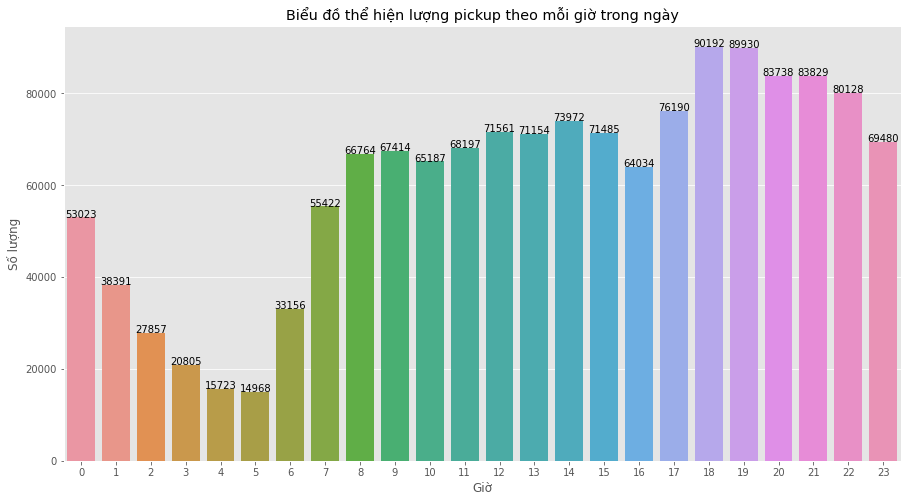

In [60]:
plt.figure(figsize=(15,8))
ax = sns.countplot(time_pickup['Hour'])
plt.title('Biểu đồ thể hiện lượng pickup theo mỗi giờ trong ngày')
plt.ylabel('Số lượng')
plt.xlabel('Giờ')
for p in ax.patches:
    height = p.get_height()
    ax.text(x = p.get_x() + (p.get_width()/2),
    y = height + 0.2, ha = 'center', s = '{:.0f}'.format(height))
plt.show()

Dựa vào biểu đồ trên, ta có thể đưa ra nhận xét rằng:

*   Giờ cao điểm nằm trong khoảng 18-23h
*   Giờ bình thường nằm trong khoảng 8-17h
*   Giờ thấp điểm nằm trong khoảng 0-7h






**Để có cái nhìn rộng hơn, ta tiếp tục vẽ số lượng pickup theo giờ biểu diễn theo từng tuần và từng tháng.**

Để biết được số lượng pick_up theo từng giờ ở từng tuần khác nhau ta sẽ tiến hành nhóm các dòng dữ liệu thành các nhóm theo từng giờ và từng tuần thông qua hàm groupby() có sẵn trong thư viện pandas khi làm việc với các dataframe, đồng thời ta cũng sử dụng size() để đếm số dòng trong mỗi nhóm này (hàm size() sẽ đếm luôn những dòng có giá trị là NA). Kết quả trả về sẽ là 1 series.

Và để vẽ được đồ thị biểu diễn số lượng pickup theo từng giờ và từng tuần, tiếp theo ta sẽ cần sử dụng hàm unstack() để biểu diễn kết quả đã groupby từ phía trên thành 1 DataFrame. Hàm này sẽ hỗ trợ xoay các nhãn chỉ mục (phải được phân cấp) 1 cấp. Tham khảo tại: https://www.w3resource.com/pandas/dataframe/dataframe-unstack.php

**Biểu đồ thể hiện lượng pickup mỗi giờ theo các tuần**

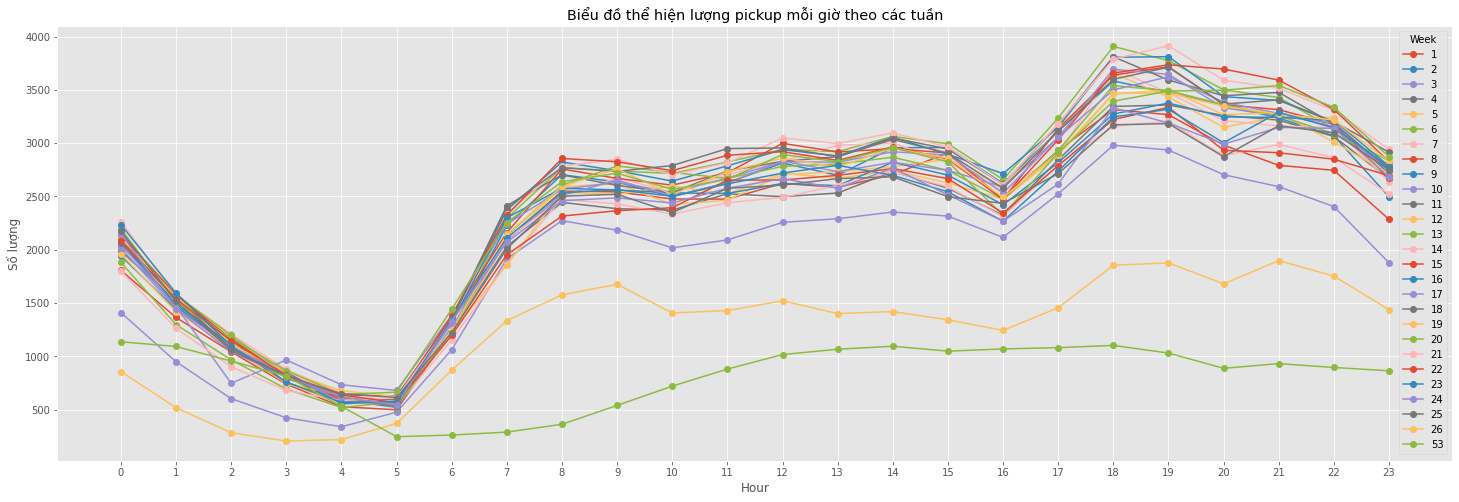

In [61]:
time_pickup.groupby(['Hour','Week']).size().unstack().plot(kind='line', title='Biểu đồ thể hiện lượng pickup mỗi giờ theo các tuần', figsize=(25, 8), legend=True,ylabel='Số lượng', marker='o',
                                                            xticks=time_pickup.Hour.value_counts().sort_index().index);

Ta nhận thấy ở tuần thứ 53 và 26 có sự bất thường so với các tuần còn lại khi có biểu đồ đường bị lệch về phía dưới, nguyên do là số lượng bản ghi ở 2 tuần này ít hơn các tuần khác rất nhiều đã dẫn đến tình trạng như trên.

In [62]:
time_pickup['Week'].value_counts(sort=True, ascending=True)[0:5] # Hàm value_counts đếm số lượng các giá trị của cột

53    19931
26    29640
3     45101
21    52099
1     52965
Name: Week, dtype: Int64

In [63]:
time_pickup.groupby(['Week', 'Weekday']).size().unstack()

Weekday,0,1,2,3,4,5,6
Week,,,,,,,
1,6687.0,7165.0,7336.0,7621.0,8199.0,8534.0,7423.0
2,7248.0,7769.0,8327.0,8238.0,8513.0,8759.0,7844.0
3,7111.0,7906.0,7989.0,8336.0,8755.0,1640.0,3364.0
4,6057.0,6905.0,7541.0,8014.0,8697.0,9135.0,7640.0
5,7035.0,7631.0,7790.0,8345.0,8452.0,8857.0,7795.0
6,7087.0,7591.0,8288.0,9083.0,9075.0,9267.0,8439.0
7,7335.0,7622.0,8161.0,8542.0,8742.0,8883.0,7653.0
8,7171.0,8131.0,8416.0,8610.0,9023.0,9193.0,7739.0
9,7369.0,7810.0,8547.0,8855.0,9189.0,9560.0,8098.0


- Ở tuần thứ 26: Dữ liệu bị khuyết ở các ngày thứ sáu, thứ bảy và chủ nhât.
- Ở tuần thứ 53: Dữ liệu bị khuyết ở các ngày thứ hai, thứ ba, thứ tư và thứ năm.

Do đó từ giờ, khi vẽ biểu đồ thể hiện các đặc điểm của dữ liệu liên quan đến từng tuần, để đảm bảo độ nhất quán cũng như tính liên tục của các nét vẽ trong biểu đồ, ta sẽ tạm thời bỏ qua 2 tuần này.

In [64]:
# Tạo một dataframe tạm, đã bỏ đi tuần 26 và 53
time_pickup_drop_26_53 = time_pickup.copy()
time_pickup_drop_26_53 = time_pickup_drop_26_53.drop(time_pickup[time_pickup['Week'] == 26].index)
time_pickup_drop_26_53 = time_pickup_drop_26_53.drop(time_pickup[time_pickup['Week'] == 53].index)

**Biểu đồ thể hiện lượng pickup mỗi giờ theo từng tháng**

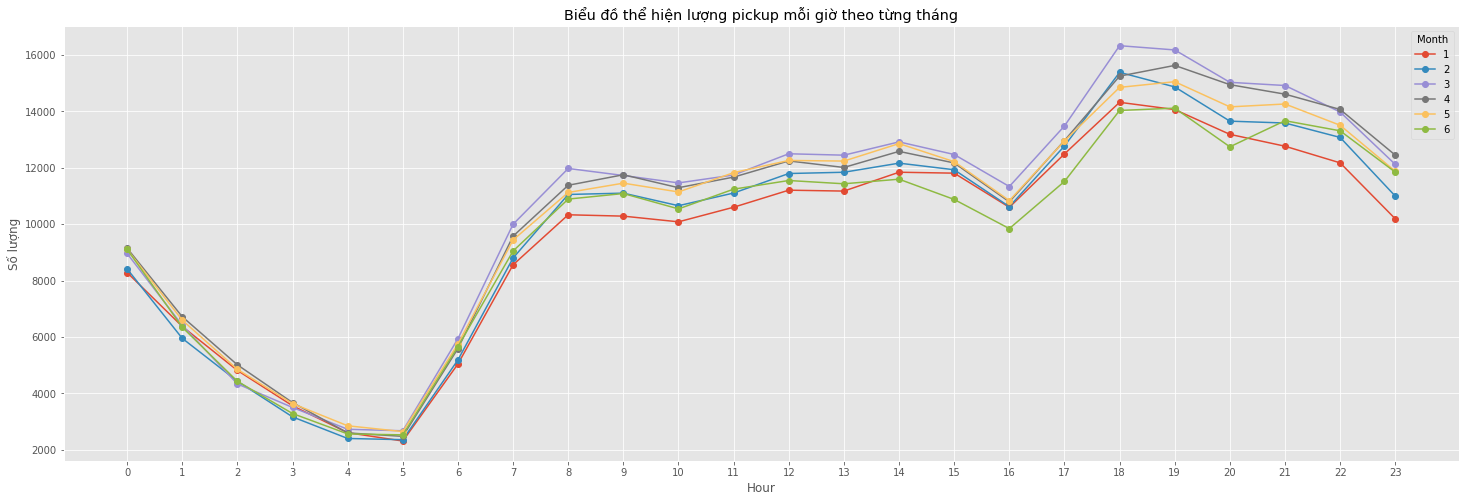

In [65]:
time_pickup.groupby(['Hour', 'Month']).size().unstack().plot(kind='line', title='Biểu đồ thể hiện lượng pickup mỗi giờ theo từng tháng', figsize=(25, 8), legend=True,ylabel='Số lượng', marker='o',
                                                                  xticks=time_pickup_drop_26_53.Hour.value_counts().sort_index().index)

Dựa vào 2 đồ thị trên ta có thể thấy các tháng và các tuần trong dữ liệu gần như tương tự nhau.

Dựa vào các kết quả phân tích ở trên ta có thể kết luận như sau:


*  Giờ cao điểm nằm trong khoảng 18-23h.
*  Giờ bình thường nằm trong khoảng 8-17h.
*  Giờ thấp điểm nằm trong khoảng 0-7h.






**Ta tìm hiểu xem số lượng pickup thay đổi như thế nào theo các ngày trong tuần**

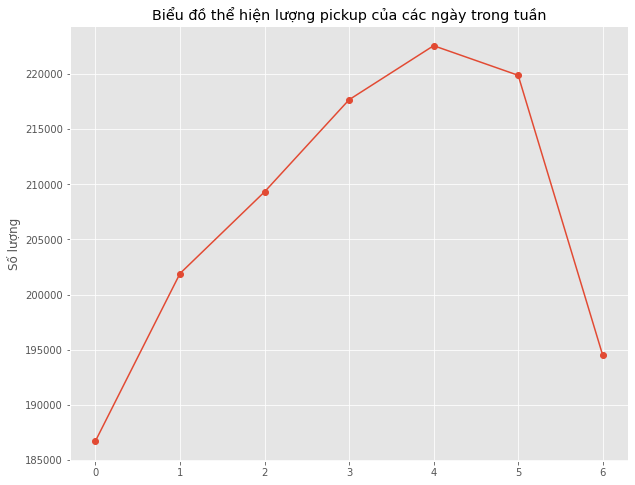

In [66]:
time_pickup['Weekday'].value_counts().sort_index().plot(kind='line',figsize=(10,8),marker='o',title='Biểu đồ thể hiện lượng pickup của các ngày trong tuần', ylabel='Số lượng')

Dựa vào đồ thị trên, ta có thể đưa ra giả thuyết rằng: 

---


- Ngày thứ 2 chính là ngày có số lượng pickup thấp nhất trong tuần, xếp sau chính là ngày chủ nhật. Ngày thứ 6 và thứ 7 là 2 ngày có số lượng pickup cao nhất trong các ngày trong tuần. Và nhìn chung, số lượng pickup có xu hương tăng dần từ đầu tuần và đạt đỉnh điểm vào ngày thứ 7, sau đó bắt đầu hạ xuống thấp vào ngày chủ nhật.

Để có cái nhìn rộng hơn, ta sẽ tiếp tục xem lượng pickup mỗi ngày theo từng tuần để đưa ra một kết luận cho giả thuyết trên.

**Biểu đồ thể hiện lượng pickup mỗi ngày theo từng tuần**

---




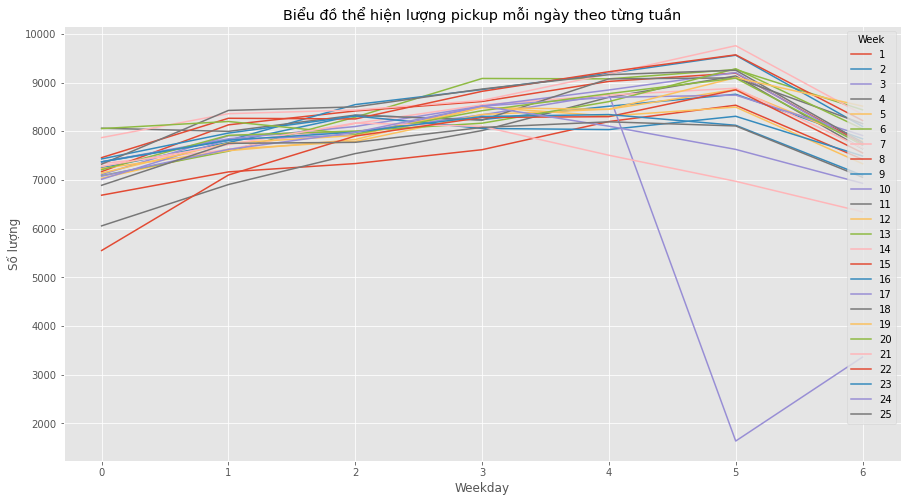

In [67]:
time_pickup_drop_26_53.groupby(['Weekday', 'Week']).size().unstack().plot(kind='line', title='Biểu đồ thể hiện lượng pickup mỗi ngày theo từng tuần', figsize=(15, 8), legend=True,ylabel='Số lượng')

Dựa vào đồ thị trên thì ta đã có một cái nhìn tổng quát hơn về số lượng pickup thay đổi theo ngày qua từng tuần, và từ đây ta có thể củng cố được giả thuyết mà ta đã đặt ra phần trước, đó là: Lượng pickup tăng dần từ ngày đầu tuần và sẽ đạt đỉnh vào thứ 6 hoặc thứ 7, sau đó sẽ giảm xuống khi bước qua ngày chủ nhật. 

Đồng thời, ta cũng nhận thấy vào ngày thứ 7 của một tuần nào đó đã có lượng pickup thấp bất thường. Ta sẽ tiến hành tìm hiểu.

**Đầu tiên, ta sẽ vẽ biểu đồ thể hiện số lượng pickup vào các ngày thứ 7 của từng tuần cụ thể**

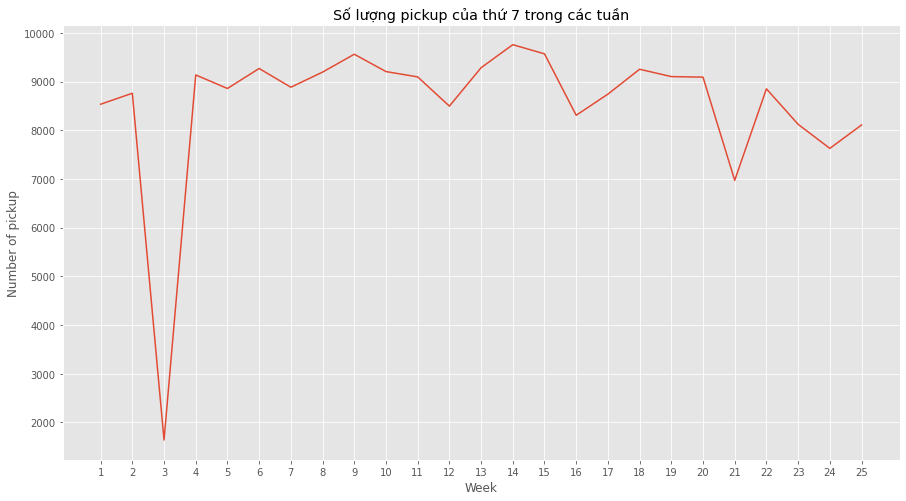

In [68]:
time_pickup_drop_26_53[time_pickup_drop_26_53['Weekday'] == 5].groupby(["Week"]).size().plot(kind='line', title='Số lượng pickup của thứ 7 trong các tuần', 
                                                                              figsize=(15, 8),ylabel='Number of pickup',xticks=time_pickup_drop_26_53.Week.value_counts().sort_index().index);

Dựa vào đồ thị, ta đã xác định được đây là thứ 7 của tuần thứ 3. Tiếp theo, ta sẽ xác định xem đây là ngày bao nhiêu.

In [69]:
# Mục đích để tìm 1 giá trị index của 1 dòng bất kỳ nào đó mang dữ liệu của thứ 7 tuần thứ 3.
temp1 = time_pickup[time_pickup['Week'] == 3]
temp2 = temp1[temp1['Weekday'] == 5]
temp2.head(1)

,Month,Weekday,Hour,Week,Distance,Trip_duration,Speed
308,1,5,8,3,1.000119,1197,3.007878


In [70]:
# Sau khi xác định index = 308, ta dùng hàm iloc để lọc ra dữ liệu của 2 cột pickup_datetime và pickoff_datetime để xác định chuỗi ngày gốc.
taxi_df.iloc[308, 2:4]

pickup_datetime     2016-01-23 08:46:42
dropoff_datetime    2016-01-23 09:06:39
Name: 308, dtype: object

Qua kết quả phía trên, ta thấy đây là ngày 23/01/2016 và là thời điểm trùng với một trận bão tuyết rất lớn tại thành phố New York, theo nguồn thông tin ghi nhận tại [bài báo này.](https://www.nbcnewyork.com/news/local/nyc-new-york-city-blizzard-biggest-ever-january-23-2016/831660/#:~:text=Snowfall%20totals%20in%20Central%20Park,National%20Oceanic%20and%20Atmospheric%20Administration.) Do đó lượng pickup của chúng ta vào ngày này rất thấp, chỉ với 1640 bản ghi.

Ta đi đến kết luận:

---

- Số lượng pickup theo chu kỳ như sau: pickup ở mức thấp vào cuối tuần (chủ nhật) và đầu tuần (thứ 2), sau đó tăng dần lên đỉnh điểm vào thứ 6 hoặc 7 và giảm xuống vào chủ nhật.
- Số lượng pickup phụ thuộc vào thời tiết, khi mà có sự kiện thời tiết cực đoan thì số lượng pickup sẽ giảm rất rõ rệt.



Đánh giá về **trip_duration** đối với mỗi khung giờ và theo các ngày trong tuần

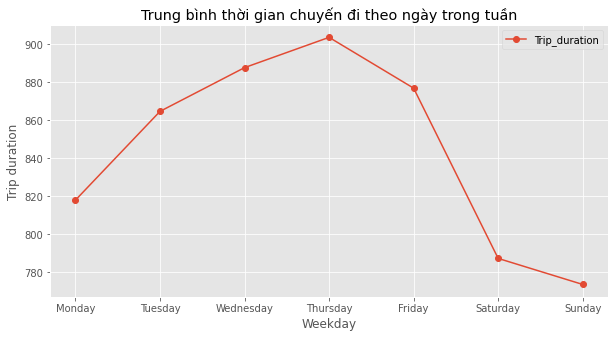

In [71]:
fig, ax = plt.subplots()
fig = time_pickup.groupby(['Weekday'])['Trip_duration'].mean().plot(kind='line', title='Trung bình thời gian chuyến đi theo ngày trong tuần', figsize=(10, 5), legend=True, ylabel='Trip duration',marker='o')
ax.set_xticklabels(["",'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']);

Dựa vào đồ thị, thời gian trung bình chuyến đi ở mức cao ở giữa tuần và thấp hơn đáng kể vào ngày thứ bảy và chủ nhật. Ta có thể đưa ra giả thuyết là cuối tuần, ít người đi làm sẽ khiến cho các chuyến đi nhanh hơn, hoặc vào ngày cuối tuần các chuyển đi sẽ ngắn hơn, tiết kiệm thời gian hơn.

Ta sẽ tìm hiểu vận tốc giữa các khung giờ như thế nào.

Text(0, 0.5, 'Distance')

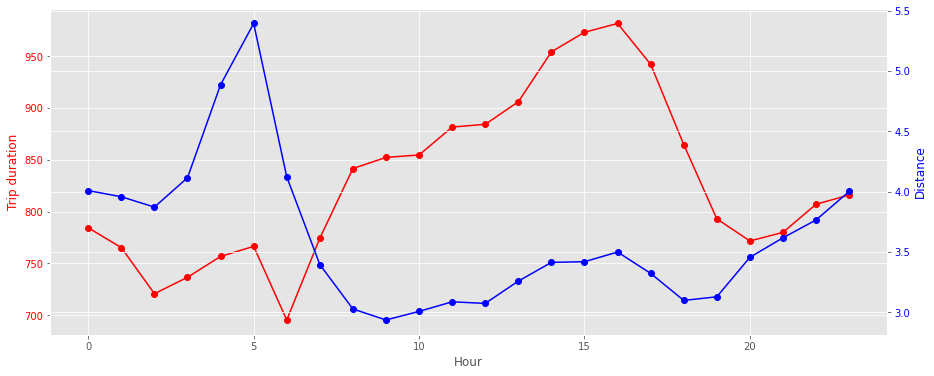

In [72]:
fig, ax =plt.subplots(1,figsize=(15,6))
plt.xlabel('Hour')
plt.ylabel('Trip duration',color="r")
plt.plot(list(time_pickup.groupby(["Hour"])["Trip_duration"].mean().index),
        list(time_pickup.groupby(["Hour"])["Trip_duration"].mean().values),"r",marker="o")
plt.tick_params(axis="y", labelcolor="r")
plt.twinx()
plt.plot(list(time_pickup.groupby(["Hour"])["Distance"].mean().index),
        list(time_pickup.groupby(["Hour"])["Distance"].mean().values),"b",marker="o")
plt.tick_params(axis="y", labelcolor="b")
plt.ylabel('Distance',color="b")

Ta đưa ra một nhận xét là thường trong khung giờ cao điểm, số lượng pickup nhiều thì thời gian di chuyển sẽ lâu hơn, nhưng ở đây biểu đồ lại cho thấy thời gian di chuyển (trip_duration) của khung giờ cao điểm lại nhanh hơn giờ bình thường và tiệm cận với khung giờ thấp điểm.

Ta có thể thấy:

- Ở khung giờ cao điểm 18-23h: Khoảng cách di chuyển xa hơn khung giờ bình thường nhưng lại có thời gian di chuyển nhanh hơn => Có thể do mật độ giao thông thấp, di chuyển nhanh.
- Ở khung giờ bình thường 8-17h: Khoảng cách di chuyển gần nhưng thời gian di chuyển di chuyển rất chậm. => Mật độ giao thông rất cao, có thể là kẹt xe.
- Ở khung giờ thấp điểm 0-7h: Khoảng cách di chuyển cao nhất, thời gian di chuyển cũng nhanh nhất => Có thể do mật độ giao thông thưa thớt, đường vắng vẻ.

Để củng cố thêm giả thuyết thì chúng ta sẽ xem Heatmap của vận tốc

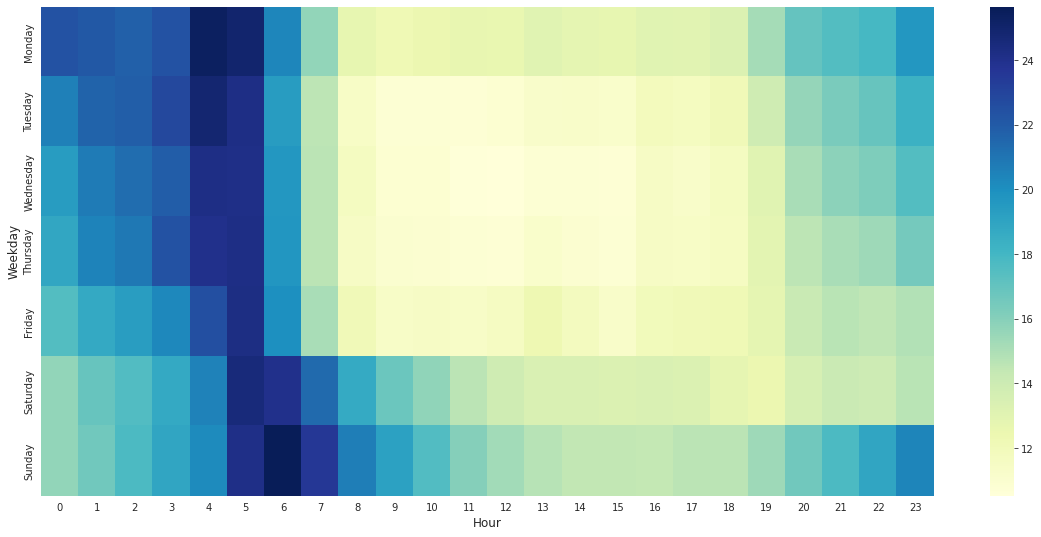

In [73]:
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(20, 9))
    ax = sns.heatmap(time_pickup.groupby(["Weekday","Hour"])["Speed"].mean().unstack(),cmap="YlGnBu")
    ax.set_yticklabels(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

- Chúng ta có thể thấy trong khung giờ từ 0h-7h thì vận tốc trung bình sẽ cao hơn các khung giờ khác.
- Ở các ngày từ thứ 2 đến thứ 6 vào các khung giờ 7h-19h thì tốc độ trung bình của các chuyến đi tương đối thấp.
- Vào 2 ngày cuối tuần là thứ 7 và chủ nhật, từ sau 11h tốc độ trung bình của chuyến đi cũng bắt đầu giảm xuống.


**Quyết định: Thêm 1 feature mới là "Low_Speed_Time" vào dataset, thể hiện các khung giờ có tốc độ di chuyển thấp, với giá trị là 1 nếu khung giờ là từ 8h-18h từ thứ 2 đến thứ 6, khung giờ 11h-22h đối với thứ 7 và 11h-18h đối với chủ nhật. Ngoài các khung giờ trên sẽ là giá trị 0.**

In [74]:
def Low_Speed_Time_func(Date):
  if Date.weekday() in [0,1,2,3,4]:
    if Date.hour in range(8,19):
      return 1
    else:
      return 0
  elif Date.weekday() == 5:
    if Date.hour in range(11,23):
      return 1
    else:
      return 0
  elif Date.weekday() == 6:
    if Date.hour in range(11,19):
      return 1
    else:
      return 0
  else:
    return 0
# Thêm cột mới vào bộ dữ liệu
taxi_df["Low_speed_time"]= taxi_df["pickup_datetime"].apply(lambda x : Low_Speed_Time_func(x))

In [75]:
taxi_df.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,distance,speed,Low_speed_time
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,False,455,1.502172,11.885316,1
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,False,663,1.808660,9.820778,0
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,False,2124,6.379687,10.813029,1
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,False,429,1.483632,12.450063,0
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,False,435,1.187038,9.823760,1


Dựa vào các phân tích đã tiến hành ở phía trên, ta có thể đưa ra 1 số kết luận liên quan đến câu hỏi số 1 như sau:


*   Số lượng đặt chuyến vào các ngày thứ 2 và chủ nhật có phần thấp hơn so với các ngày còn lại trong tuần. Trong khi đó các ngày giữa tuần như thứ 6, thứ 7 được nhiều lượt pickup hơn so với các ngày còn lại.
*   Những ngày có hiện tượng thời tiết cực đoan sẽ có lượng pickup rất thấp, do người dân có xu hướng không đi ra ngoài vào các ngày này. Vậy ta có kết luận rằng lượng pickup bị ảnh hưởng đáng kể bởi thời tiết, nhất là các hình thái thời tiết cực đoan.
*   Các chuyến đi trong khung giờ từ 0h - 7h là những chuyến đi dài với tốc độ nhanh nhất so với khung giờ khác, có thể vì đây là thời điểm có mật độ giao thông thông thoáng.
*   Các chuyến đi trong khung giờ từ 8h - 17h là những chuyến đi có khoảng cách di chuyển ngắn nhưng lại tốc độ chậm nhất trong các khung giờ.
*   Các chuyến đi ở khung giờ từ 18h - 23h là những chuyến đi nằm trong khung giờ cao điểm, có khoảng cách di chuyển ngắn với tốc độ nhanh.







###**Câu hỏi phân tích số 2.** Có gì đáng chú ý ở vị trí điểm đón và trả khách của các chuyến đi hay không?

Ở phần này, ta sẽ tìm hiểu xem liệu các điểm đón trả khách trong tập dữ liệu có đem đến thông tin hữu ích gì cho chúng ta hay không, ví dụ như nơi nào tập trung nhiều chuyến đi nhất hay liệu vị trí đón trả khách cũng có thể làm ảnh hưởng đến độ dài của chuyến đi hay không?

Tại đây, chúng ta sẽ sử dụng thư viện matplotlib basemap toolkit để vẽ các bản đồ minh họa, ưu điểm của thư viện này là rất nhẹ và dễ dàng để làm quen, sử dụng.

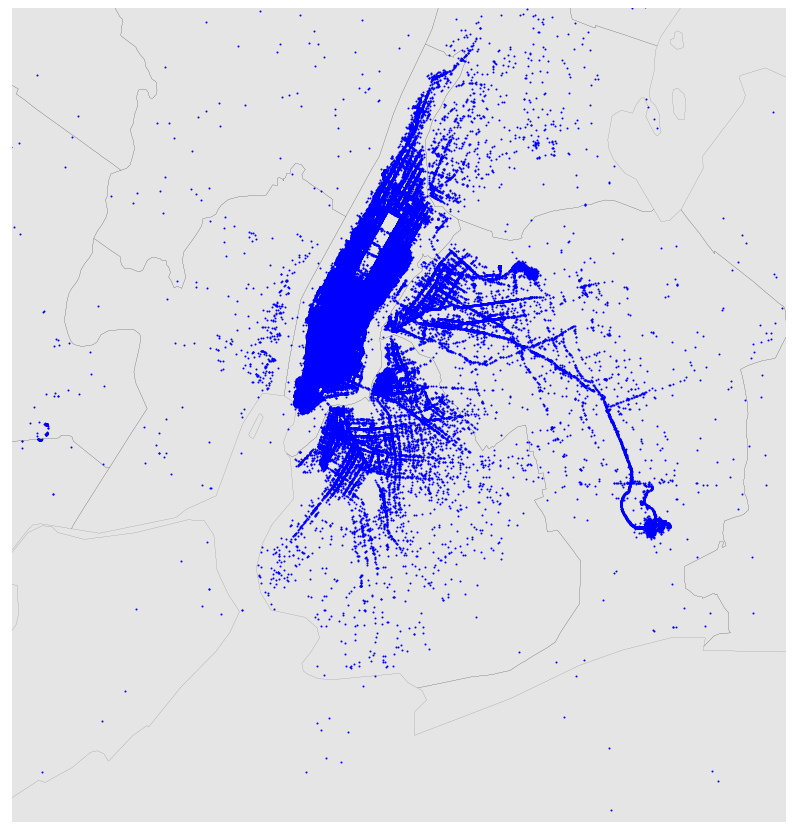

In [76]:
plt.figure(figsize=(15,15))

# Set the limits of the map to the minimum and maximum coordinates
lat_min = 40.5
lat_max = 40.9
lon_min = -74.2
lon_max = -73.7

# Set the center of the map
cent_lat = (lat_min + lat_max) / 2
cent_lon = (lon_min + lon_max) / 2

#Create the Basemap object with required params.
map = Basemap(llcrnrlon=lon_min,
              llcrnrlat=lat_min,
              urcrnrlon=lon_max,
              urcrnrlat=lat_max,
              resolution='l',
              projection='tmerc',
              lat_0 = cent_lat,
              lon_0 = cent_lon)

#Style the map
map.drawcounties()

#Fetch the long and lat in form of array
long = np.array(taxi_df["pickup_longitude"])
lat = np.array(taxi_df["pickup_latitude"])

x, y = map(long, lat)
map.plot(x, y,'bo', markersize=1, alpha=1)
plt.xticks()
plt.show()

Dựa vào biểu đồ trên, ta thấy: 
- Các điểm đón khách đa số đều nằm ở quận Manhattan. Đây là quận có dân số đông nhất NYC, có nhiều công viên, nhà hàng, địa điểm giải trí nên vì vậy khách du lịch có lẽ thường di chuyển từ địa điểm này đến địa điểm khác trong khu vực bằng taxi.
- Ta cũng nhận thấy có một con đường nối liền quận Manhattan với một địa điểm nhỏ ở góc dưới phía bên tay phải cũng có khá nhiều chuyến xe đón khách ở đây - Trên thực tế, đây chính là Sân bay quốc tế John F. Kennedy, sân bay này cũng nằm khá xa trung tâm quận Manhattan.
- Ngoài ra cũng có một sân bay khác có vị trí gần trung tâm hơn so với sân bay John F. Kennedy, đó là Sân bay LaGuardia cũng là nơi tập trung nhiều lượt đến và đi trong ngày.

Nhận xét chủ quan:
- Chắc hẳn sẽ có một số chuyến đi đường dài đến và đi từ sân bay.
- Tương tự như vậy, thời gian trung bình cho các chuyến xe được đón đến hoặc đến sân bay sẽ dài hơn các chuyến xe đi và đến trong trung tâm.

**Biểu đồ thể hiện sự phân bố của các điểm trả khách (dropoff)**

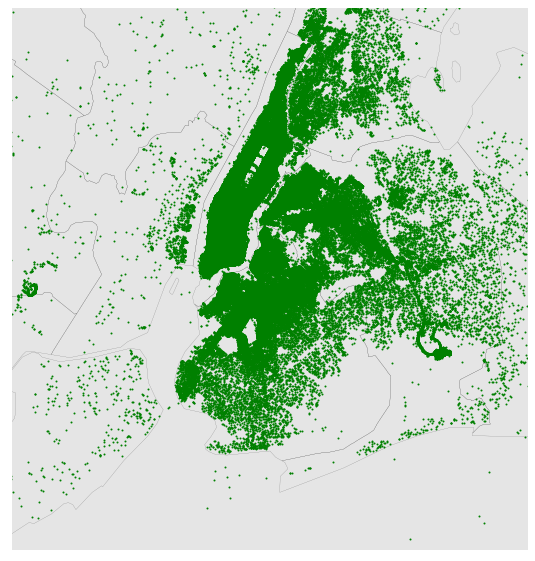

In [77]:
plt.figure(figsize=(10,10))

# Set the limits of the map to the minimum and maximum coordinates
lat_min = 40.5
lat_max = 40.9
lon_min = -74.2
lon_max = -73.7

# Set the center of the map
cent_lat = (lat_min + lat_max) / 2
cent_lon = (lon_min + lon_max) / 2

#Create the Basemap object with required params.
map = Basemap(llcrnrlon=lon_min,
              llcrnrlat=lat_min,
              urcrnrlon=lon_max,
              urcrnrlat=lat_max,
              resolution='l',
              projection='tmerc',
              lat_0 = cent_lat,
              lon_0 = cent_lon)

#Style the map
map.drawcounties()

#Fetch the long and lat in form of array
long = np.array(taxi_df["dropoff_longitude"])
lat = np.array(taxi_df["dropoff_latitude"])

x, y = map(long, lat)
map.plot(x, y,'go', markersize=1, alpha=1)
plt.xticks()
plt.show()

Quan sát bản đồ, ta thấy các địa điểm trả khách đã phân bố đều hơn, rộng khắp hơn các địa điểm đón khách, lan ra xung quanh các khu vực của NYC. Nhưng ta cũng nhận thấy rằng, Manhattan vẫn là nơi có nhiều chuyến xe tập trung đến trả khách nhất.

Tiếp theo, ta sẽ tạm định nghĩa chuyến dài là những chuyến có khoảng cách lớn hơn 50km. Ta cũng có thể nhận ra điều này khi xem phân bố của cột distance khi mà phần lớn các chuyến đi đều có khoảng cách di chuyển dưới 50km và trong thực tế để đi một vòng NYC ta cũng sẽ cần đi 1 khoảng là 48.28km.

In [78]:
short_trips = taxi_df[taxi_df['distance'] <= 50]
long_trips = taxi_df[taxi_df['distance'] > 50]

Ta sẽ xem vị trí các điểm đón của các chuyến đi dài vì có thể các chuyến này sẽ xuất phát từ các sân bay đi vào trung tâm quận Manhattan. Tại đây ta có sử dụng thư viện folium để hỗ trợ vễ bản đồ phía dưỡi, cho phép chúng ta thấy rõ được vị trí của các địa điểm quan trọng cần chú ý.



In [79]:
#Khởi tạo bản đồ focus tại New York City
nyc_map = folium.Map(location=[40.730610, -73.935242], zoom_start=11, tiles='Stamen Terrain')

#Vẽ các điểm đón (màu xanh)
long_trip_points = folium.map.FeatureGroup()
for lat, lng, in zip(long_trips.pickup_latitude, long_trips.pickup_longitude):
    long_trip_points.add_child(
            folium.features.CircleMarker(
                [lat, lng],
                radius=5,
                color='yellow',
                fill=True,
                fill_color='blue',
                fill_opacity=0.6
            )
        )

#Vẽ các điểm trả (màu đỏ)
for lat, lng, in zip(long_trips.dropoff_latitude, long_trips.dropoff_longitude):
    long_trip_points.add_child(
            folium.features.CircleMarker(
                [lat, lng],
                radius=5,
                color='yellow',
                fill=True,
                fill_color='red',
                fill_opacity=0.6
            )
        )
nyc_map.add_child(long_trip_points)

Quan sát bản đồ, ta thấy điểm đón khách của các chuyến đi dài này tập trung ở 3 khu vực chính là khu Manhattan, sân bay John F. Kennedy và sân bay LaGuardia. Còn các điểm trả khách đa số nằm ngoài phạm vi thành phố New York. Manhattan cũng chiếm đa số điểm đón các chuyến dài

**Như vậy, cũng có những chuyến xe xuất phát từ 2 sân bay này và có cự ly di chuyển dài (>50 km), điều này cũng sẽ dẫn đến thời gian di chuyển của chuyến đi sẽ dài hơn, nhưng liệu rằng ta có nên thêm một thuộc tính mới đánh dấu những chuyến xe có điểm đón hoặc điểm trả nằm gần 2 sân bay kể trên để đưa vào tập dữ liệu huấn luyện mô hình hay không?**

Có thể tham khảo thêm tài liệu về 2 thư viện đã được sử dụng ở phía trên: 


1.   Thư viện mpl_toolkits.basemap: https://matplotlib.org/basemap/
2.   Thư viện folium: https://python-visualization.github.io/folium/



## Huấn luyện mô hình dự đoán tổng thời gian di chuyển của chuyến đi (trip_duration)

Ta sẽ thử chạy các mô hình giống nhau về bản chất, ở đây chúng ta sẽ chọn mô hình XGBoost, để huấn luyện so sánh kết quả giữa các mô hình với data khác nhau để thấy được sự thay đổi của kết quả nếu một hay tất cả thuộc tính vừa được feature engineer tìm ra.

Cuộc thi New York City Taxi Trip Duration đặt ra bài toán dự đoán tổng thời gian của một chuyến taxi ở thành phố New York (Mỹ) dựa vào các thông tin như tọa độ điểm đón và trả khách, thời gian đón khách, số lượng hành khách. Với output là tổng thời gian dự đoán của chuyến đó tính bằng giây. Thì chúng ta thử dự đoán và đánh giá kết quả.

Qua việc tìm hiểu và phân tích tập dữ liệu thì chúng ta đã có thêm hiểu biết hơn về dữ liệu. Với những giả thuyết được đưa ra thì chúng ta có những feature tiêu biểu như sau:


*   Weekday: Thứ mấy trong tuần, nằm trong đoạn [0, 6]
*   Hour: Giờ trong ngày, thuộc khoảng [0,23]
*   pickup_longitude: Vị trí điểm đón
*   pickup_latitude: Vị trí điểm đón
*   dropoff_longitude: Vị trí điểm trả
*   dropoff_latitude: Vị trí điểm trả
*   distance: Khoảng cách giữa điểm đón và trả
*   speed: Tốc độ của chuyến đi.
*   Low_speed_time: Khung giờ có tốc độ trung bình thấp.

**Tiền xử lý**

In [80]:
train = pd.read_csv('https://media.githubusercontent.com/media/trunghq0205/python4ds/main/train.csv')
test = pd.read_csv('https://media.githubusercontent.com/media/trunghq0205/python4ds/main/test.csv')

Trước tiên, để làm cho công việc được liền mạch cũng như tránh sai sót, ở đây chúng ta sẽ có một hàm gom lại tất cả các việc đã làm ở phần trước.

In [81]:
def get_distance(trip):
    pickup_coord = (trip['pickup_latitude'], trip['pickup_longitude'])
    dropoff_coord = (trip['dropoff_latitude'], trip['dropoff_longitude'])
    return geopy.distance.distance(pickup_coord, dropoff_coord).km

#def Low_Speed_Time_func(Date):
#    if Date.weekday() in [0,1,2,3,4]:
#        if Date.hour in range(8,18):
#            return 1
#        else:
#            return 0
#    else:
#        return 0

def Low_Speed_Time_func(Date):
  if Date.weekday() in [0,1,2,3,4]:
    if Date.hour in range(8,19):
      return 1
    else:
      return 0
  elif Date.weekday() == 5:
    if Date.hour in range(11,23):
      return 1
    else:
      return 0
  elif Date.weekday() == 6:
    if Date.hour in range(11,19):
      return 1
    else:
      return 0
  else:
    return 0

# add feature
def Generate_Feature(df,isTrain):
    # Chuyển cột pickup_datetime sang kiểu datetime
    df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'], format='%Y-%m-%d %H:%M:%S')
    # Chuyển cột pickoff_datetime sang kiểu datetime
    if (isTrain == True):
        df['dropoff_datetime'] = pd.to_datetime(df['dropoff_datetime'], format='%Y-%m-%d %H:%M:%S')
    # Chuyển cột "store_and_fwd_flag" sang kiểu bool
    df['store_and_fwd_flag'] = df['store_and_fwd_flag'].apply(lambda ele: False if ele == 'N' else True)
    # Chuyển cột "vendor_id" sang kiểu string
    df['vendor_id'] = df['vendor_id'].astype(str)

    # Thêm cột khoảng cách di chuyển
    df['distance'] = df.apply(get_distance, axis = 1)
    # Thêm cột tốc độ
    if (isTrain == True):
      df['speed'] = df.distance/df.trip_duration*3600

    if (isTrain == True):
        # Xóa các chuyến có lượng hành khách là 0,7,8,9
        df.drop(df[df['passenger_count'].isin([0, 7, 8, 9])].index, inplace = True)
        # Xóa các chuyến có trip_duration > 82600
        df.drop(df[df['trip_duration'] > 82600].index, inplace = True)
        # Xóa các chuyến đi có khoảng cách di chuyển bằng 0 và thời gian di chuyển lớn hơn 120 giây
        zero_distance_trips = df[(df['pickup_latitude'] == df['dropoff_latitude']) & \
            (df['pickup_longitude'] == df['dropoff_longitude'])]
        df.drop(zero_distance_trips[zero_distance_trips['trip_duration'] > 120].index, inplace=True)
        # Xóa các chuyến đi có tốc độ >= 100km/h
        df.drop(df[df['speed'] >= 100].index, inplace = True)

    df.reset_index(drop=True, inplace=True)
    
    # Thêm feature Low_speed_time - Khung giờ tốc độ thấp
    df["Low_speed_time"] = df["pickup_datetime"].apply(lambda x : Low_Speed_Time_func(x))
  

    # Feature engineering
    dst_df=pd.DataFrame()
    dst_df["weekday"]=df["pickup_datetime"].apply(lambda x: x.weekday())
    dst_df["weekday"]=dst_df["weekday"]
    dst_df["hour"]=df["pickup_datetime"].apply(lambda x: x.hour)
    dst_df['pickup_longitude']=df['pickup_longitude']
    dst_df['pickup_latitude']=df['pickup_latitude']
    dst_df['dropoff_longitude']=df['dropoff_longitude']
    dst_df['dropoff_latitude']=df['dropoff_latitude']
    dst_df['distance']=df['distance']
    dst_df['passenger_count']=df['passenger_count']
    dst_df['vendor_id'] = df['vendor_id']
    dst_df['store_and_fwd_flag']=df['store_and_fwd_flag']
    dst_df["Low_speed_time"]= df["pickup_datetime"].apply(lambda x : Low_Speed_Time_func(x))

    if(isTrain == True):
        dst_df['trip_duration']=df['trip_duration']
    dst_df = dst_df.dropna(axis=0, how='any')
    return dst_df

In [82]:
Train = Generate_Feature(train,True)
Train.to_csv("Train_feature.csv",index=False)
Train = pd.read_csv("Train_feature.csv")
Train = pd.read_csv("Train_feature.csv")


# Tách tập dữ liệu train thành Y và X dùng để train model
Y_train = Train['trip_duration'] # Y là cột trip_duration
X_train = Train.drop(columns=['trip_duration']) # X là các thuộc tính còn lại
pickle.dump((X_train,Y_train), open("feature_train_data.pkl", "wb")) # ghi ra file nhị phân


Test = Generate_Feature(test, False)
Test.to_csv("Test_feature.csv",index=False)
Test = pd.read_csv("Test_feature.csv")
pickle.dump((Test), open("feature_test_data.pkl", "wb"))  # ghi ra file nhị phân

Ở phía trên để thuận tiện cho việc đọc các tập Train và Test sau này, ta có sử dụng thư viện pickle để làm việc với file nhị phân. Pickle được sử dụng để thực hiện chuyển đổi các cấu trúc đối tượng Python sang một dạng byte để có thể được lưu trữ trên ổ đĩa hoặc được gửi cho người khác qua mạng. Sau đó, luồng ký tự này sau đó có thể được truy xuất và chuyển đổi trở lại sang dạng đối tượng ban đầu trong Python.

Xem thêm tài liệu về thư viện Pickle tại: https://docs.python.org/3/library/pickle.html

Để thuận tiện thì ta chỉ cần đọc dữ liệu thông qua file pickle đã được xử lý ở phía trên.

In [83]:
(X,Y) = pickle.load(open("feature_train_data.pkl", "rb"))
X_test = pickle.load(open("feature_test_data.pkl", "rb"))
X1_Train = X[["weekday","hour","pickup_longitude","pickup_latitude","dropoff_longitude","dropoff_latitude","passenger_count","vendor_id", "store_and_fwd_flag"]]
X1_test = X_test[["weekday","hour","pickup_longitude","pickup_latitude","dropoff_longitude","dropoff_latitude","passenger_count","vendor_id", "store_and_fwd_flag"]]

X2_Train = X[["weekday","hour","pickup_longitude","pickup_latitude","dropoff_longitude","dropoff_latitude","passenger_count","vendor_id", "store_and_fwd_flag", "distance"]]
X2_test = X_test[["weekday","hour","pickup_longitude","pickup_latitude","dropoff_longitude","dropoff_latitude","passenger_count","vendor_id", "store_and_fwd_flag", "distance"]]

X3_Train = X[["weekday","hour","pickup_longitude","pickup_latitude","dropoff_longitude","dropoff_latitude","passenger_count","vendor_id", "store_and_fwd_flag", "Low_speed_time"]]
X3_test = X_test[["weekday","hour","pickup_longitude","pickup_latitude","dropoff_longitude","dropoff_latitude","passenger_count","vendor_id", "store_and_fwd_flag", "Low_speed_time"]]


X4_Train = X[["weekday","hour","pickup_longitude","pickup_latitude","dropoff_longitude","dropoff_latitude","passenger_count","vendor_id", "store_and_fwd_flag", "distance", "Low_speed_time"]]
X4_test = X_test[["weekday","hour","pickup_longitude","pickup_latitude","dropoff_longitude","dropoff_latitude","passenger_count","vendor_id", "store_and_fwd_flag", "distance", "Low_speed_time"]]

Để so sánh chúng ta sẽ chọn ra 4 tập dữ liệu tiêu biểu khác nhau và sử dụng chung 1 model:
*   X1: Dữ liệu gốc bao gồm các cột: **weekday**, **hour**, **pickup_longitude**, **pickup_latitude**, **dropoff_longitude**, **dropoff_latitude**, **passenger_count**, **vendor_id**, **store_and_fwd_flag**.
*   X2: Là dữ liệu X1 nhưng có thêm thuộc tính **distance**
*   X3: Là dữ liệu X1, nhưng có thêm thuộc tính **Low_speed_time**.
*   X4: Là dữ liệu X1, nhưng có thêm thuộc tính **distance** và **Low_speed_time**.

Đối với model XGBoost thì ta cũng dùng XGBoost không tinh chỉnh

In [84]:
xgbr = xgb.XGBRegressor()
xgbr.fit(X1_Train, Y)
#predict
preds = xgbr.predict(X1_test)
# save to csv
df = pd.DataFrame()
df["id"] = pd.read_csv("https://media.githubusercontent.com/media/trunghq0205/python4ds/main/test.csv")["id"]
df["trip_duration"] = preds
df.to_csv("XGB_1.csv", index = False)

[08:29:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [85]:
xgbr = xgb.XGBRegressor()
xgbr.fit(X2_Train, Y)
#predict
preds = xgbr.predict(X2_test)
# save to csv
df = pd.DataFrame()
df["id"] = pd.read_csv("https://media.githubusercontent.com/media/trunghq0205/python4ds/main/test.csv")["id"]
df["trip_duration"] = preds
df.to_csv("XGB_2.csv", index = False)

[08:31:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [86]:
xgbr = xgb.XGBRegressor()
xgbr.fit(X3_Train, Y)
#predict
preds = xgbr.predict(X3_test)
# save to csv
df = pd.DataFrame()
df["id"] = pd.read_csv("https://media.githubusercontent.com/media/trunghq0205/python4ds/main/test.csv")["id"]
df["trip_duration"] = preds
df.to_csv("XGB_3.csv", index = False)

[08:34:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [87]:
xgbr = xgb.XGBRegressor()
xgbr.fit(X4_Train, Y)
#predict
preds = xgbr.predict(X4_test)
# save to csv
df = pd.DataFrame()
df["id"] = pd.read_csv("https://media.githubusercontent.com/media/trunghq0205/python4ds/main/test.csv")["id"]
df["trip_duration"] = preds
df.to_csv("XGB_4.csv", index = False)

[08:36:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


**Kết Quả**

Toàn bộ dữ liệu dự đoán sẽ được upload trên kaggle để tính private score và public score. Kết quả như sau:
*   Model 1: Public score: 0.65572, Private score: 0.65763
*   Model 2: Public score: 0.49539, Private score: 0.49437
*   Model 3: Public score: 0.63515, Private score: 0.6374
*   Model 4: Public score: 0.49284, Private score: 0.49216

<img src='https://github.com/trunghq0205/python4ds/blob/main/Images/Model_score.png?raw=true' align="left"/>

Nhận xét:
- Khi huấn luyện mô hình với tập dữ liệu gốc, kết quả cho ra sai số là cao nhất với public score: 0.65572 và private score: 0.65763
- Thuộc tính distance có sự tương quan với trip_duration tốt hơn thuộc tính Low_speed_time khi train model cho ra kết quả tốt hơn.
- Ta thấy model 4 khi thêm thuộc tính distance và Low_speed_time có độ chính xác cao hơn các model còn lại.


**Vì vậy khi huấn luyện mô hình ta cần có quá trình tìm hiểu và trích xuất ra các thuộc tính mới (feature engineering) nhằm cải thiện độ chính xác cho model**

## Tổng kết

...........